# 주식 종목 이슈 요약

* 데이터 : 검색상위 종목리스트, 뉴스본문

* 가설 : 
    - 뉴스에 많이 언급될수록 주가가 큰 폭으로 움직인다.
    - 주가가 큰 폭으로 움직였던 종목일수록, 이에 대한 기사가 많이 나온다.

* 예상되는 결과 : 
    - 주가 변동이 큰 종목일수록, 또는 거래량이 많은 종목은 이슈가 되는 원인이 있기 마련이다.
    - 뉴스에서 언급되는 종목 이슈가 있다면 주가에 영향을 줄 것이고, 반대로 주가에 큰 변동이 있었던 종목일수록 그 원인과 관련한 뉴스가 많이 보도될 수 있다.
    - 이슈가 되는 종목들의 키워드를 비교함으로써 시장상황을 보여줄 수도 있다.
    
* 행동계획
    - 주가 변동의 원인에 대해 관련 뉴스를 요약한 결과를 통해 빠르게 파악하고, 주식시장의 이슈에 대해 알아보자.



# 확인할 종목 선정

* 종목 선정 기준
    - 최근 검색상위 종목 Top10
* 수집 방법
    - '금융홈 > 국내증시' 페이지에서 종목코드와 종목명 크롤링
    - http://finance.naver.com/sise/lastsearch2.nhn

# 종목리스트 수집

In [288]:
%matplotlib inline
import requests
import lxml.html
from urllib.parse import urljoin
import csv
from konlpy.tag import Kkma, Komoran
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from matplotlib import pyplot
import networkx
tagger = Komoran()

def get_word(doc):
    nouns = tagger.nouns(doc)
    return [noun for noun in nouns if len(noun) > 1]

In [289]:
list_url = 'http://finance.naver.com/sise/lastsearch2.nhn'
response = requests.get(list_url)

In [290]:
root = lxml.html.fromstring(response.content)

In [291]:
item_nm1 = []
for i in range(0,10):
    temp = root.find_class("type_5")[0].xpath('//tr/td/a')[i]
    print(temp.text_content())
    item_nm1.append(temp.text_content())

NAVER
SK하이닉스
크리스탈
엘컴텍
파세코
서울전자통신
현대상선
OCI
영진약품
기아차


# 뉴스 스크랩

In [294]:
i = 0
for x in item_nm1:
    i = i + 1
    board_url = 'http://openapi.naver.com/search?key=e3d9c03963f5ca1d83a511d93842f097&query='+x+'%20주식&target=news&start=1&display=100'
    response = requests.get(board_url)
    root = lxml.html.fromstring(response.content)
    f = open('news_scrap'+str(i)+'.txt', 'w', encoding='utf8')

    for node in root.xpath('//*/item'):

        # 게시물 리스트 제목 출력
        f.write(node.xpath('title')[0].text_content())    
        # 게시물 본문 URL
        f.write(node.xpath('description')[0].text_content())
    f.close()


# 상위검색 종목 Top10 - Word Cloud

* 고도화 포인트
    - 단어 리스트에서 종목명, 상투적인 단어 등을 제거하고 이슈에 관한 키워드를 최대한 남길 수 있도록 고도화



종목명: NAVER


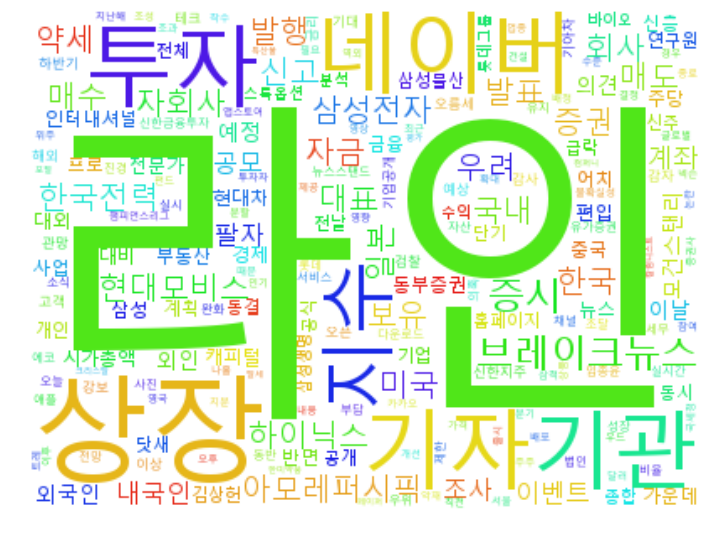



종목명: SK하이닉스


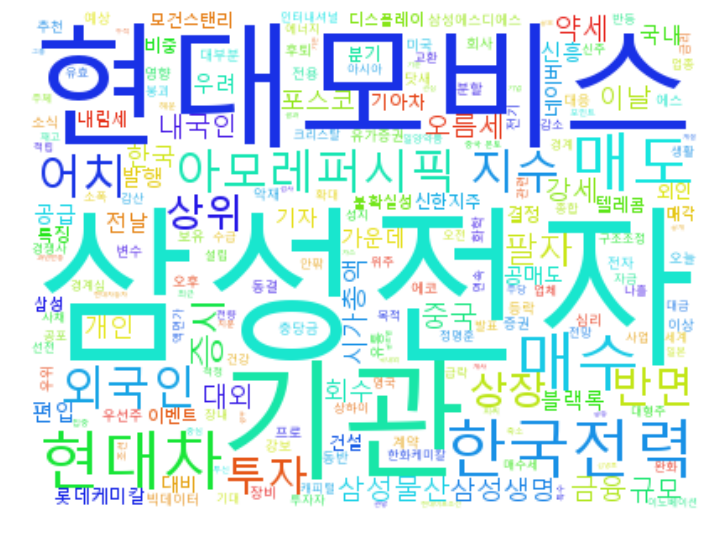



종목명: 크리스탈


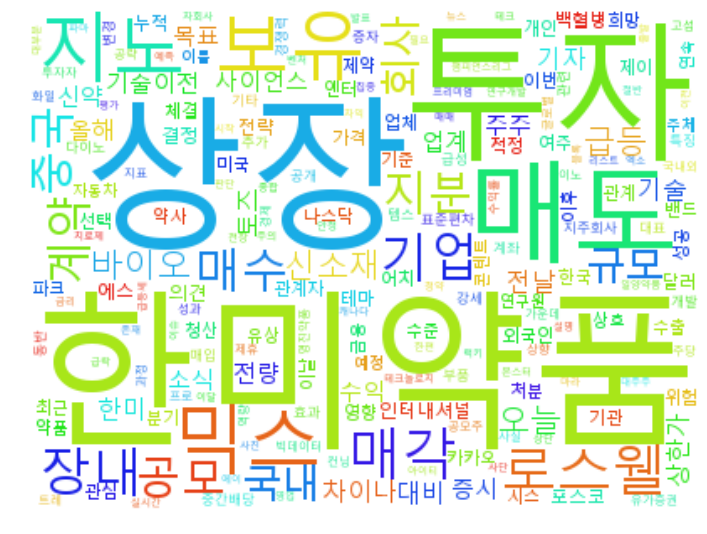



종목명: 엘컴텍


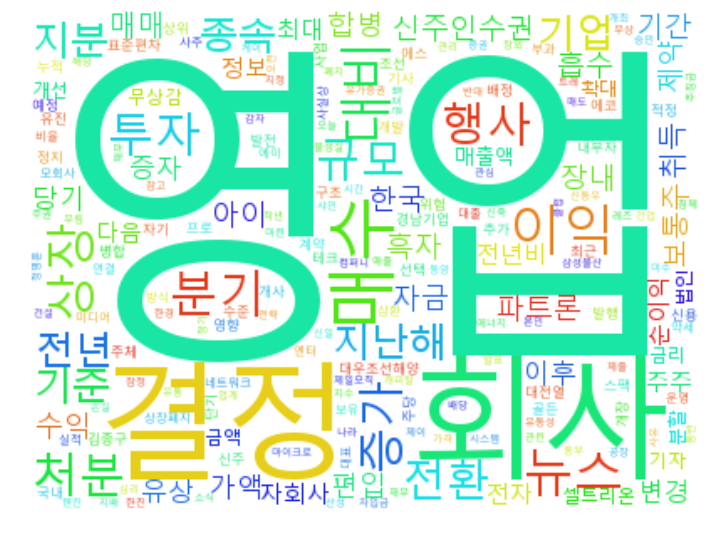



종목명: 파세코


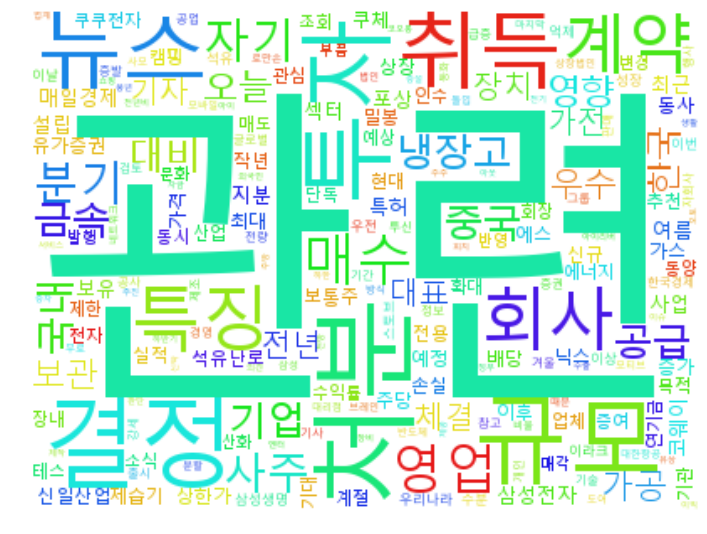



종목명: 서울전자통신


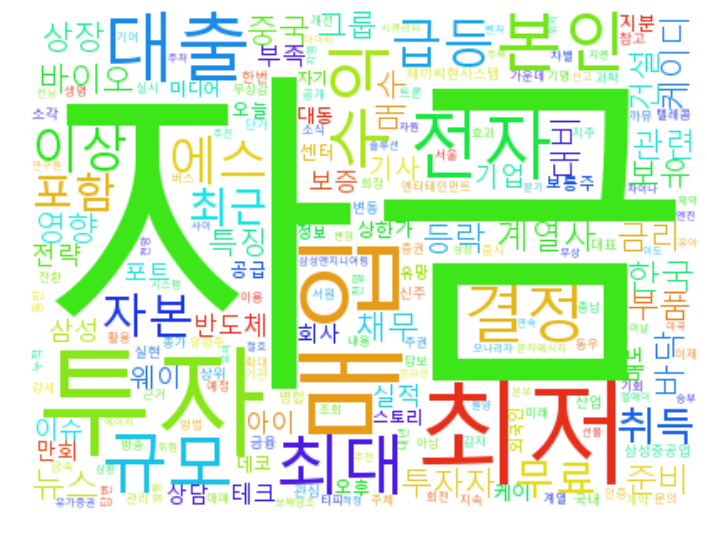



종목명: 현대상선


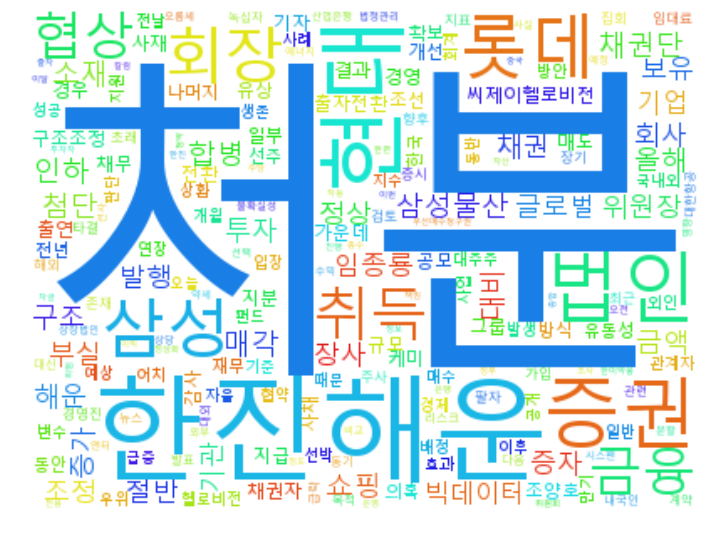



종목명: OCI


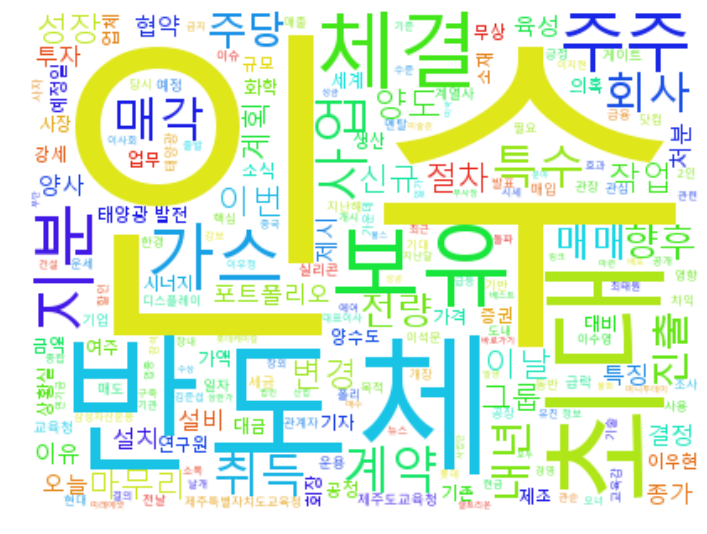



종목명: 영진약품


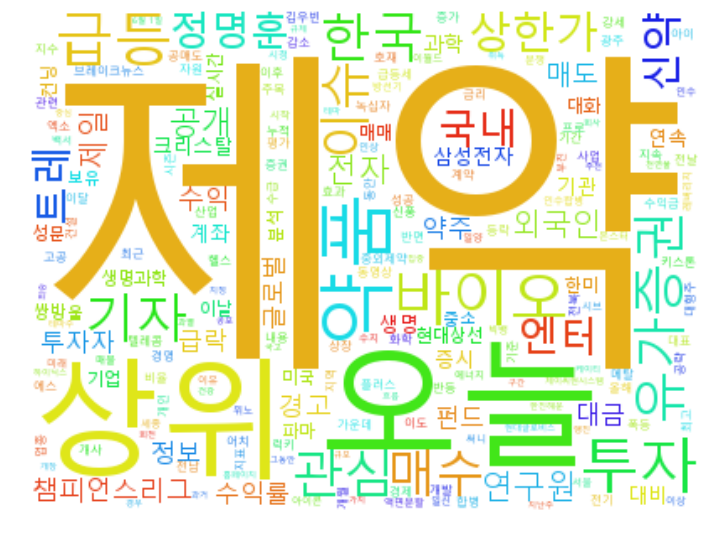



종목명: 기아차


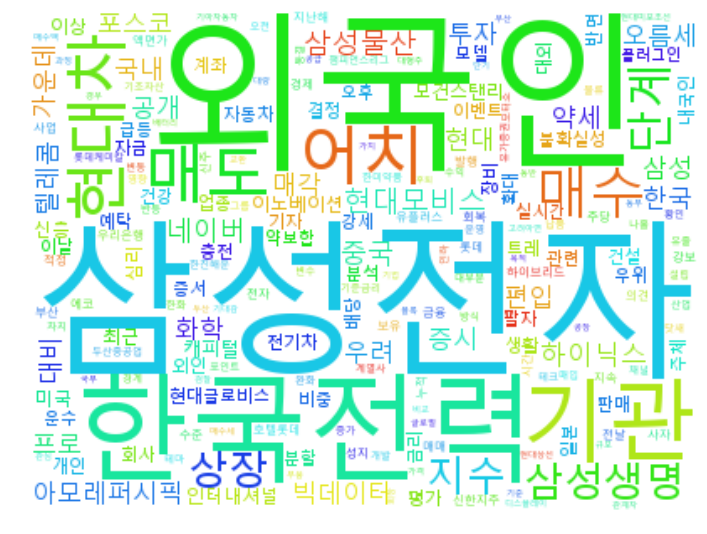

In [296]:
for i in range(1,11):


    with open('news_scrap'+str(i)+'.txt', encoding='utf8', newline='\r\n') as f:
        reader = csv.reader(f)
        for row in reader:
            news = ' '.join(row)
    news = news.replace(item_nm1[i-1], ' ')
    news = news.replace('코스피', ' ')
    news = news.replace('코스닥', ' ')
    news = news.replace('종목', ' ')
    news = news.replace('하락', ' ')
    news = news.replace('상승', ' ')
    news = news.replace('거래', ' ')
    news = news.replace('마감', ' ')
    news = news.replace('기록', ' ')
    news = news.replace('공시', ' ')
    news = news.replace('시장', ' ')
    news = news.replace('주가', ' ')
    news = news.replace('주식', ' ')
    
    cv = CountVectorizer(tokenizer=tagger.nouns, max_features=5000)
    cv = CountVectorizer(tokenizer=get_word, max_features=5000)
    tdf = cv.fit_transform(news.split('\n'))
    words = cv.get_feature_names()
    count = numpy.squeeze(numpy.asarray(tdf.sum(axis=0)))
    word_count = list(zip(cv.get_feature_names(), count))
    sorted(word_count, key=operator.itemgetter(1), reverse=True)
    for x in word_count:
        if x[0] < 'a': word_count.remove(x)
    
    print('\n\n종목명: '+item_nm1[i-1])
    wc = WordCloud(font_path='C:\\Windows\\Fonts\\malgun.ttf', background_color='white', width=400, height=300)
    cloud = wc.generate_from_frequencies(word_count)
    pyplot.figure(figsize=(12, 9))
    pyplot.imshow(cloud)
    pyplot.axis("off")
    pyplot.show()
    